In [38]:
pwd

'/Users/yangsun/Desktop/Bootcamp/Project-1/API_code'

In [1]:
import pandas as pd
import gmaps
import requests
from config import (gkey,census_api)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import json
import requests
import html5lib
import lxml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import random



# Goal: Where should Panda Express expand their businesses? 

In [6]:
dataset_dict = {"master_dataset1":"master_data",
              "us_cities_states_counties":"city"}


In [34]:
## read in data function
def read_csvdata()-> None:
    global dataset_dict, name
    for dataset, name in dataset_dict.items():
        if dataset=="us_cities_states_counties":
            name = pd.read_csv(f"../dataset/USA-cities-and-states/{dataset}.csv", sep="|")
            return name

        else:
            name = pd.read_csv(f"../dataset/{dataset}.csv")
            return name


In [35]:
read_csvdata()

,Column 1,zip_code,yelp_rating,price_tag,review_count,lat,lng,name,name 2,storeid,...,Median Age,Household Income,Per Capita Income,Poverty Count,Unemployment,city_name,state_name,state_name 2,Walk Score,Bike Score
0,0,91210,2.0,$$,41.0,34.145200,-118.259400,Panda Express,1,1,...,35.2,159500,93135,188,21,GLENDALE,CA,West,90,63.0
1,1,91210,2.0,$,25.0,34.145100,-118.258900,Panda Express,1,161,...,35.2,159500,93135,188,21,GLENDALE,CA,West,88,63.0
2,2,91210,2.0,$,117.0,34.145146,-118.259298,Chipotle,0,277,...,35.2,159500,93135,188,21,GLENDALE,CA,West,90,63.0
3,3,30096,3.5,$,58.0,33.955900,-84.131800,Panda Express,1,2,...,35.1,53514,28011,8901,1677,DULUTH,GA,South,58,46.0
4,4,30096,3.0,$,126.0,33.955240,-84.131099,Chipotle,0,861,...,35.1,53514,28011,8901,1677,DULUTH,GA,South,56,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,5376,98901,2.5,$$,51.0,46.613916,-120.511168,Red Lobster,2,683,...,30.4,40437,18216,8257,852,YAKIMA,WA,West,61,54.0
5377,5377,25701,3.0,$$,21.0,38.423513,-82.442233,Red Lobster,2,685,...,40.2,36022,28529,5226,498,HUNTINGTON,WV,East,77,80.0
5378,5378,26101,3.0,$$$,19.0,39.297170,-81.547218,Red Lobster,2,687,...,39.7,34259,21225,7717,1019,PARKERSBURG,WV,East,52,30.0
5379,5379,53220,2.5,$$,74.0,42.960442,-88.008841,Red Lobster,2,691,...,41.1,53328,31331,2836,374,MILWAUKEE,WI,Midwest,66,48.0


## Dataset manipulation

In [21]:
# read in data
master_data = pd.read_csv("../dataset/master_dataset1.csv")
city = pd.read_csv("../dataset/USA-cities-and-states/us_cities_states_counties.csv", sep="|")
city = city[["City","State short"]].drop_duplicates()
city


,City,State short
0,Holtsville,NY
2,Adjuntas,PR
6,Aguada,PR
12,Aguadilla,PR
45,Maricao,PR
...,...,...
63206,Klawock,AK
63207,Metlakatla,AK
63208,Point Baker,AK
63209,Ward Cove,AK


In [22]:
# change city name to lower case and create new column called 'join' (city + state) in order to remove duplicates
city["city_lower"] = [str(name).lower() for name in city["City"]]
city["join"] = city["city_lower"]+"-"+city["State short"]


In [26]:
# change city name to lower case in maseter dataset and calculate unemployment rate and poverty rate
master_data["city_name_lower"] = [name.lower() for name in master_data["city_name"]]
master_data["join"] = master_data["city_name_lower"]+"-"+master_data["state_name"]
master_data["uemp_rate"] = master_data["Unemployment"]/master_data["Population"]*100
master_data["poverty_rate"] = master_data["Poverty Count"]/master_data["Population"]*100
master_data

,Column 1,zip_code,yelp_rating,price_tag,review_count,lat,lng,name,name 2,storeid,...,Unemployment,city_name,state_name,state_name 2,Walk Score,Bike Score,city_name_lower,join,uemp_rate,poverty_rate
0,0,91210,2.0,$$,41.0,34.145200,-118.259400,Panda Express,1,1,...,21,GLENDALE,CA,West,90,63.0,glendale,glendale-CA,3.047896,27.285922
1,1,91210,2.0,$,25.0,34.145100,-118.258900,Panda Express,1,161,...,21,GLENDALE,CA,West,88,63.0,glendale,glendale-CA,3.047896,27.285922
2,2,91210,2.0,$,117.0,34.145146,-118.259298,Chipotle,0,277,...,21,GLENDALE,CA,West,90,63.0,glendale,glendale-CA,3.047896,27.285922
3,3,30096,3.5,$,58.0,33.955900,-84.131800,Panda Express,1,2,...,1677,DULUTH,GA,South,58,46.0,duluth,duluth-GA,2.467664,13.097603
4,4,30096,3.0,$,126.0,33.955240,-84.131099,Chipotle,0,861,...,1677,DULUTH,GA,South,56,40.0,duluth,duluth-GA,2.467664,13.097603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,5376,98901,2.5,$$,51.0,46.613916,-120.511168,Red Lobster,2,683,...,852,YAKIMA,WA,West,61,54.0,yakima,yakima-WA,2.645634,25.639672
5377,5377,25701,3.0,$$,21.0,38.423513,-82.442233,Red Lobster,2,685,...,498,HUNTINGTON,WV,East,77,80.0,huntington,huntington-WV,2.385629,25.034731
5378,5378,26101,3.0,$$$,19.0,39.297170,-81.547218,Red Lobster,2,687,...,1019,PARKERSBURG,WV,East,52,30.0,parkersburg,parkersburg-WV,3.378871,25.588567
5379,5379,53220,2.5,$$,74.0,42.960442,-88.008841,Red Lobster,2,691,...,374,MILWAUKEE,WI,Midwest,66,48.0,milwaukee,milwaukee-WI,1.445187,10.958692


In [34]:
# find out cities where have no panda express
px_city_state = master_data["join"]
no_px_city = city.loc[~city["join"].isin(px_city_state),].reset_index()
no_px_city = no_px_city.drop(columns = "index")
no_px_city


,City,State short,city_lower,join
0,Holtsville,NY,holtsville,holtsville-NY
1,Adjuntas,PR,adjuntas,adjuntas-PR
2,Aguada,PR,aguada,aguada-PR
3,Aguadilla,PR,aguadilla,aguadilla-PR
4,Maricao,PR,maricao,maricao-PR
...,...,...,...,...
27932,Klawock,AK,klawock,klawock-AK
27933,Metlakatla,AK,metlakatla,metlakatla-AK
27934,Point Baker,AK,point baker,point baker-AK
27935,Ward Cove,AK,ward cove,ward cove-AK


In [35]:
print(f"Panda Express exists {round(1-len(no_px_city)/len(city),2)*100}% of cities in US")


Panda Express exists 6.0% of cities in US


## Pre Analysis - understand the dataset

In [36]:
# separate out panda express data from master dataset
px_data = master_data.loc[master_data["name"]=="Panda Express",]


#### Yelp rating difference in different areas

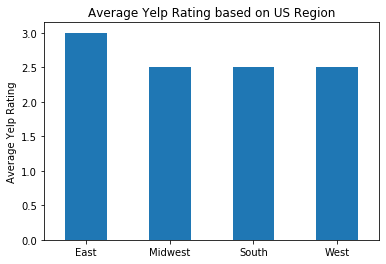

In [37]:
px_data.groupby("state_name 2").agg(rating = ("yelp_rating","median")).plot(kind = "bar", rot = 0, legend = False)
plt.xlabel("")
plt.ylabel("Average Yelp Rating")
plt.title("Average Yelp Rating based on US Region")
plt.show()


#### There is a 0.5 difference in yelp rating for px stores in east coast and other areas, so we need to create another var in the dataset to differntiate east area and other areas. 1 is east, 0 is non-east

In [38]:
px_data["area"] = [1 if region =="East" else 0 for region in px_data["state_name 2"]]


/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Descriptive statitics between variables with yelp rating

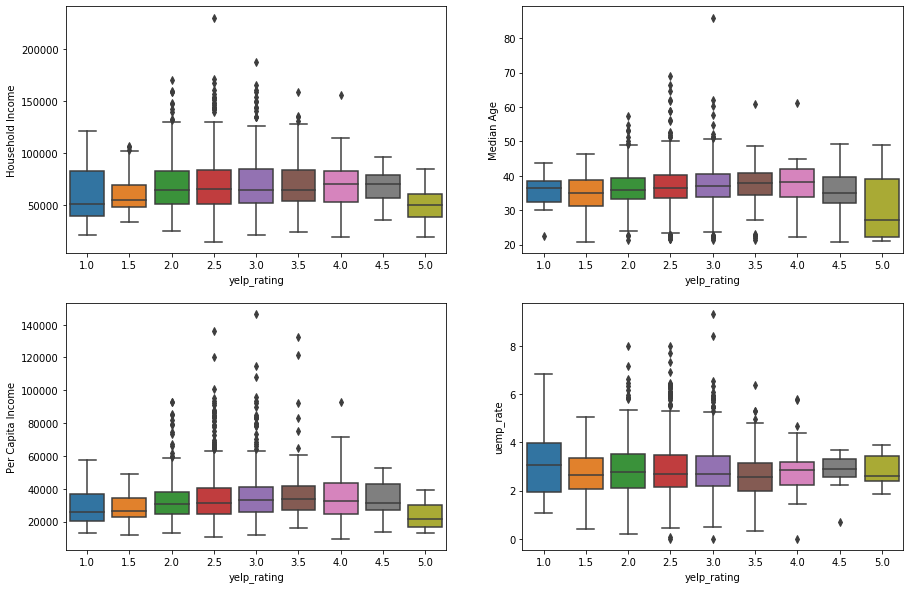

In [39]:
fig, axs = plt.subplots(ncols=2,nrows = 2, figsize = (15,10))

sns.boxplot(x = "yelp_rating", y = "Household Income", data = px_data, ax=axs[0,0])
sns.boxplot(x = "yelp_rating", y = "Per Capita Income", data = px_data,ax=axs[1,0])
sns.boxplot(x = "yelp_rating", y = "Median Age", data = px_data,ax=axs[0,1])
sns.boxplot(x = "yelp_rating", y = "uemp_rate", data = px_data,ax=axs[1,1])

plt.show()


#### Distribution of variables

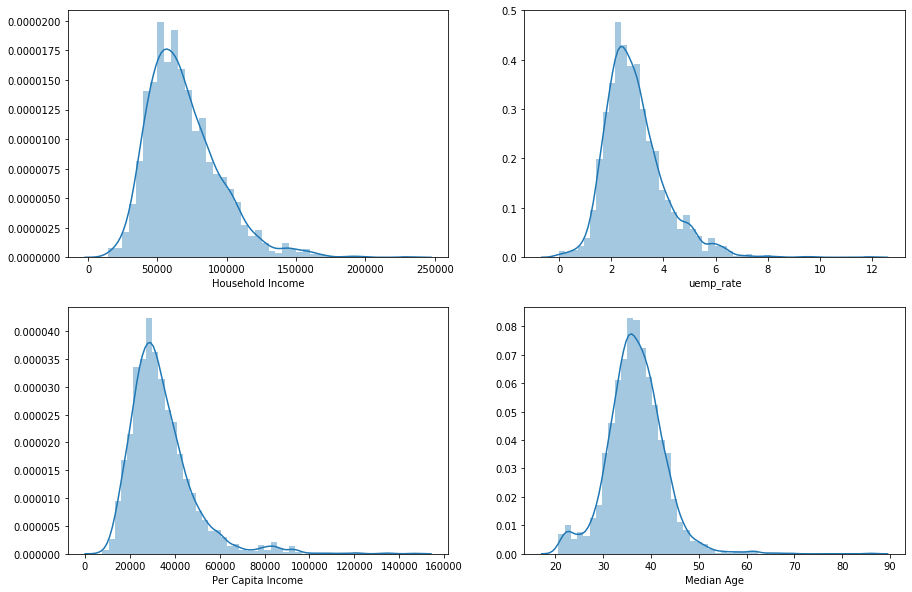

In [42]:
fig, axs = plt.subplots(ncols=2,nrows = 2, figsize = (15,10))

sns.distplot(px_data["Household Income"],ax=axs[0,0])
sns.distplot(px_data["Per Capita Income"],ax=axs[1,0])
sns.distplot(px_data["uemp_rate"],ax=axs[0,1])
sns.distplot(px_data["Median Age"],ax=axs[1,1])

plt.show()


## Analysis - fit a linear model

In [47]:
# remove stores with missing yelp rating
px_data_nona = px_data.loc[~pd.isnull(px_data["yelp_rating"]),]


In [49]:
# independent and dependent variables
x = px_data_nona[["Median Age","Per Capita Income","uemp_rate","Household Income","area"]]
y = px_data_nona["yelp_rating"]


In [50]:
# fit into linear model
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            yelp_rating   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              6812.
Date:                Mon, 18 May 2020   Prob (F-statistic):                        0.00
Time:                        16:00:25   Log-Likelihood:                         -1891.1
No. Observations:                1999   AIC:                                      3792.
Df Residuals:                    1994   BIC:                                      3820.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Median Age            0.0480      0.002     29.073      0.000       0.045       0.051
Per Capita Income -2.222e-06   1.62e-06     -1.374      0.170   -5.39e-06     9.5e-07
uemp_rate             0.1673      0.011     14.847      0.000       0.145       0.189
Household Income   5.227e-06   8.51e-07      6.139      0.000    3.56e-06     6.9e-06
area                  0.2519      0.058      4.365      0.000       0.139       0.365
==============================================================================
Omnibus:                      255.686   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              649.396
Skew:                           0.711   Prob(JB):                    9.67e-142
Kurtosis:                       5.403   Cond. No.                     3.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Based on linear model, unemployment rate `uemp_rate` is the most relevant varibles to yelp rating, `Per Capita  Income` variable is not significant

#### Compare predicted yelp rating with actual yelp rating, and the difference is about 0.5 on average

In [51]:
y_true = y.to_list()
y_pred = predictions.to_list()

test =[abs(x - y) for (x,y) in zip(y_true, y_pred)]
pd.Series(test).describe()


count    1999.000000
mean        0.472052
std         0.406963
min         0.000014
25%         0.178707
50%         0.389546
75%         0.644316
max         3.382103
dtype: float64

#### Now, let's look at the distribution of Panda Express locations in US to see where is the opportunity to open more stores

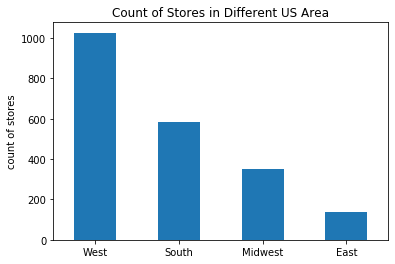

In [54]:
count_store= px_data.groupby("state_name 2").agg(count_of_store = ("name", "count")).sort_values(by = "count_of_store", ascending = False)
count_store.plot(kind = "bar",rot = 0, legend = False, title= "Count of Stores in Different US Area")
plt.xlabel("")
plt.ylabel("count of stores")
plt.show()

#### East coast area has fewer than 200 stores, so let's focus on opening new stores in East coast area

#### find out all the cities where have no panda express restaurants and merge with census data in order to predicted the yelp rating

In [55]:
# read in zipcode file and merge with census data by zipcode
city_list = pd.read_json("../dataset/US-Zip-Codes-JSON/USCities.json")
census = pd.read_csv("../dataset/census_data.csv").rename(columns = {"Zipcode": "zip_code"})

# find out city and state name for census data
census_city = pd.merge(census, city_list, on = "zip_code")
census_city["join"] = census_city["city"] +"-"+ census_city["state"]



In [57]:
# read in zipcode file and merge with census data by zipcode
city_list = pd.read_json("../dataset/US-Zip-Codes-JSON/USCities.json")
city_list["city_lower"] = [name.lower() for name in city_list["city"]]
city_list["join"] = city_list["city_lower"] +"-"+city_list["state"]
census = pd.read_csv("../dataset/census_data.csv").rename(columns = {"Zipcode": "zip_code"})

West = ["WA", "OR", "CA", "NV", "ID", "UT", "AZ", "NM", "CO", "WY", "MT","HI","AK"]
Midwest = ["ND", "SD", "NE", "KS","MN", "IA", "MO", "WI", "IL","IN","MI","OH"]
East = ["ME","VT","NH","MA","NY", "RI", "CT","NJ","PA","DE", "MD","WV","VA"]
South = ["KY","TN","NC","SC","GA","AL","FL","MS","AR","LA","OK","TX"]

# east area city and state
east_area = city.loc[city["State short"].isin(East),]
# east area city and state have panda
east_px_data = px_data.loc[px_data["state_name 2"]=="East",]["join"].drop_duplicates()

east_area_no_px = east_area.loc[~east_area["join"].isin(east_px_data),]
east_area_no_px.groupby("State short").agg(count_city = ("City","count")).sort_values(by = "count_city", ascending = False)

# find out all the zip code for these cities and state
east_area_no_px = (pd.merge(east_area_no_px, city_list, on = "join")
                   [["city_lower_x", "join","zip_code",   # select columns
                    "latitude","longitude","state","county"]]
                   .rename(columns = {"city_lower_x":"city_lower"})) # rename columns



east_area_no_px["area"] = [1 if state in East else 0 for state in east_area_no_px["state"]]


In [58]:
# get census data for `east_area_no_px`
east_area_no_px_census = pd.merge(east_area_no_px, census_city.iloc[:,0:7], on = "zip_code", how= "left")
east_area_no_px_census["uemp_rate"] = east_area_no_px_census["Unemployment"]/east_area_no_px_census["Population"]*100
east_area_no_px_census_clean = east_area_no_px_census.dropna(axis = 0)


#### Predict yelp rating in east area for non-na dataset

In [59]:
x_values = east_area_no_px_census_clean[['Median Age', 'Per Capita Income', 'uemp_rate', 'Household Income','area']]

east_area_no_px_census_clean["prediction"] = model.predict(x_values)


/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Because we treated yelp rating as continuous variable, for any predicted number which is greater than 5, we change to 5.

In [60]:
east_area_no_px_census_clean["pred_rating_new"] = [5 if rate>5 else rate for rate in east_area_no_px_census_clean["prediction"]]
east_area_no_px_census_clean["pred_rating_new"] = round(east_area_no_px_census_clean["pred_rating_new"],1)


/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Let's take a look at the predicted yelp rating dataset

In [62]:
east_area_no_px_census_clean.sort_values("pred_rating_new", ascending = False).head()


,city_lower,join,zip_code,latitude,longitude,state,county,area,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Unemployment,uemp_rate,prediction,pred_rating_new
2902,cross river,cross river-NY,10518,41.2699,-73.6121,NY,Westchester,1,1231.0,55.1,198255.0,74303.0,19.0,107.0,8.692120,5.221723,5.0
5213,lucernemines,lucernemines-PA,15754,40.5002,-79.1766,PA,Indiana,1,641.0,52.2,71969.0,23795.0,0.0,121.0,18.876755,6.238772,5.0
5816,plainfield,plainfield-PA,17081,40.203,-77.2848,PA,Cumberland,1,372.0,65.0,37000.0,26572.0,50.0,50.0,13.440860,5.754565,5.0
8794,eccles,eccles-WV,25836,37.7792,-81.2635,WV,Raleigh,1,555.0,27.6,25437.0,8585.0,332.0,130.0,23.423423,5.609520,5.0
3558,denver,denver-NY,12421,42.2357,-74.5697,NY,Delaware,1,274.0,61.1,60375.0,61084.0,5.0,26.0,9.489051,4.951685,5.0


## Visualization - Create a heatmap to map out all the location based on predicted yelp rating. 

In [63]:
east_area_no_px_census_clean['latitude'] = pd.to_numeric(east_area_no_px_census_clean['latitude'],errors='coerce')
east_area_no_px_census_clean['longitude'] = pd.to_numeric(east_area_no_px_census_clean['longitude'],errors='coerce')

east_area_no_px_census_clean = east_area_no_px_census_clean.dropna(axis = 0)
east_area_no_px_census_clean = east_area_no_px_census_clean.reset_index()



/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yangsun/opt/anaconda3/envs/gmaps/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
num = int(input("number of restaurants you want to see. "))

rows = random.sample(east_area_no_px_census_clean.index.to_list(), k = num)
selected_data = east_area_no_px_census_clean.iloc[rows, :]
selected_data = selected_data.sort_values(by = "pred_rating_new", ascending = False)



number of restaurants you want to see.  300


In [65]:
pred_rating = selected_data["pred_rating_new"]
location = selected_data[["latitude", "longitude"]]

# select 10 markers to show
selected_data_marker = selected_data.iloc[0:10, :]
marker_location = selected_data_marker.iloc[:,[4,5]]

info_text = [f"Predicted_yelp_rating: {row[17]} <br> City: {row[1]}<br> Zip Code:{row[3]} <br> State: {row[6]} <br> Population: {row[9]} <br> Unemployment Rate: {round(row[15],2)}" for index, row in selected_data_marker.iterrows()]




In [66]:
gmaps.configure(api_key=gkey)
fig = gmaps.figure()

markers = gmaps.marker_layer(marker_location, info_box_content=info_text)

# heatmap based on pred rating
rating_layer = gmaps.heatmap_layer(location, weights=pred_rating,dissipating= False, 
                                   max_intensity=max(pred_rating), point_radius=0.2)
fig.add_layer(rating_layer)
fig.add_layer(markers)
fig



Figure(layout=FigureLayout(height='420px'))

#### Visualize exsiting panda express yelp rating heatmap

In [67]:
location = px_data[["lat","lng"]]
rating = px_data["yelp_rating"]

fig = gmaps.figure()

# heatmap based on pred rating
rating_layer = gmaps.heatmap_layer(location, weights=rating,dissipating= False, 
                                   max_intensity=max(rating), point_radius=0.15)
fig.add_layer(rating_layer)
fig


Figure(layout=FigureLayout(height='420px'))